In [1]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from langgraph_supervisor import create_supervisor
from langgraph.prebuilt import create_react_agent
import os
from pydantic import BaseModel
import warnings
from typing import Literal
from openai import BaseModel
warnings.filterwarnings("ignore")
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.store.memory import InMemoryStore
import datetime
import os
from fpdf import FPDF
from docx import Document

In [2]:
load_dotenv()
model = ChatOpenAI()

In [3]:
CHECKPOINTER = InMemorySaver()
STORE = InMemoryStore()

In [4]:
class FileFormat(BaseModel):
    format: Literal["pdf", "doc", "docx"] = "doc"

# Tools

In [5]:
#@tool
def finance_research_tool(topic: str) -> str:
    """
    Search for the finance topic on web using TavilySearch
    """

    tavilly_tool = TavilySearch(max_results=5, topic="finance")
    response = tavilly_tool.invoke({"query": topic})
    return response

#@tool
def general_research_tool(topic: str) -> str:
    """
    Search for the general topic on web using TavilySearch
    """

    tavilly_tool = TavilySearch(max_results=5, topic="general")
    response = tavilly_tool.invoke({"query": topic})
    return response

In [6]:
@tool
def add(a: float, b: float) -> float:
    """Add two numbers."""
    return a + b

@tool
def multiply(a: float, b: float) -> float:
    """Multiply two numbers."""
    return a * b

In [7]:
@tool
def get_summary(response: str) -> str:
    """Generate and return a concise summary of the given response."""
    summary = model.invoke(f"Generate summary of {response} in 300 words.")
    return summary

In [8]:
@tool
def save_doc_tool(file_format: FileFormat, content: str):
    """
    Saves the provided content into a document file in either PDF or DOC format.
    The file is saved inside an 'output' folder with a timestamped filename.
    """

    os.makedirs("output", exist_ok=True)

    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    ext = file_format.format.lower()
    filename = f"output/document_{timestamp}.{ext}"

    if ext == "pdf":
        pdf = FPDF()
        pdf.add_page()
        pdf.set_auto_page_break(auto=True, margin=15)
        pdf.set_font("Arial", size=12)
        for line in content.split('\n'):
            pdf.cell(0, 10, line, ln=True)
        pdf.output(filename)
        return f"PDF saved successfully at {filename}"

    elif ext == "doc" or ext == "docx":
        doc = Document()
        for line in content.split('\n'):
            doc.add_paragraph(line)
        doc.save(filename)
        return f"DOC saved successfully at {filename}"

    else:
        return "Unsupported file format. Please use 'pdf' or 'doc'."

# Agents

In [9]:
research_agent = create_react_agent(
    model=model,
    tools=[finance_research_tool, general_research_tool],
    name="research_agent",
    prompt="""You are a world class researcher with access to finance_research_tool and general_research_tool.
    For general research, use general_research_tool.
    For finance, use finance_research_tool.
    Do not do any math."""
)

In [10]:
math_agent = create_react_agent(
    model=model,
    tools=[add, multiply],
    name="math_agent",
    prompt="You are a math expert. Always use one tool at a time."
)

In [11]:
summary_agent = create_react_agent(
    model=model,
    tools=[get_summary],
    name="summary_agent",
    prompt="You are a summary generator expert."
)

In [12]:
doc_saving_agent = create_react_agent(
    model=model,
    tools=[save_doc_tool],
    name="doc_saving_agent",
    prompt="You are a doc saving expert."
)

## Mid-Level Supervisors

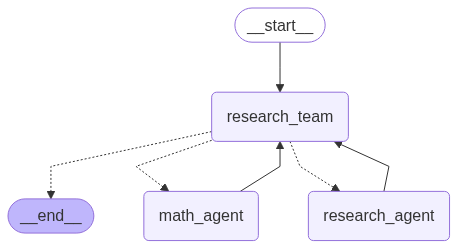

In [14]:
research_team = create_supervisor(
    [research_agent, math_agent],
    model=model,
    prompt="""
    You are the research supervisor managing two specialized agents: research_agent and math_agent.
    DO NOT answer user queries yourself.

    Your tasks:
    1. Route general (non-math) queries to research_agent.
    2. When the research_agent returns data that requires numeric calculations (like totals or sums), parse the relevant numbers from the response.
    3. Formulate math queries to the math_agent to compute the required sums step-by-step.
    4. Collect math_agent’s results and combine them if necessary.
    5. Pass the final processed answer to the top_level_supervisor.

    Always use the math_agent for any numeric calculations, do not calculate yourself.
    """,
    supervisor_name="research_team"
).compile(name="research_team")

research_team

# Top Level Supervisor

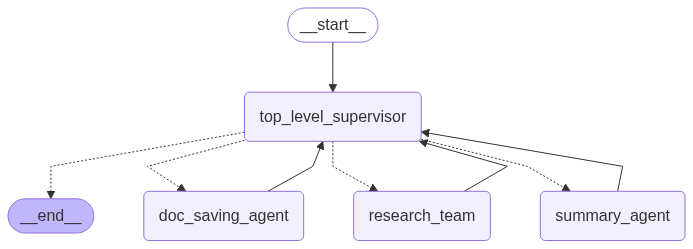

In [48]:
top_level_supervisor = create_supervisor(
    [research_team, summary_agent, doc_saving_agent],
    model=model,
    prompt="""
     You are the top-level supervisor overseeing a research_team, a summary_agent, and a doc_saving_agent.
    Delegate initial research and data collection tasks to research_team.
    Use summary_agent to generate and present the final summarized response.
    Use doc_saving_agent to save the final summarized response in pdf or doc format.
    """,
    supervisor_name="top_level_supervisor"
).compile(name="top_level_supervisor")

top_level_supervisor

In [49]:
result = top_level_supervisor.invoke({
    "messages": [
        {
            "role": "user",
            "content": "Difference between AI and ML and save as a pdf."
        }
    ]
})

Task top_level_supervisor with path ('__pregel_pull', 'top_level_supervisor') wrote to unknown channel is_last_step, ignoring it.
Task top_level_supervisor with path ('__pregel_pull', 'top_level_supervisor') wrote to unknown channel remaining_steps, ignoring it.
Task top_level_supervisor with path ('__pregel_pull', 'top_level_supervisor') wrote to unknown channel is_last_step, ignoring it.
Task top_level_supervisor with path ('__pregel_pull', 'top_level_supervisor') wrote to unknown channel remaining_steps, ignoring it.
Task top_level_supervisor with path ('__pregel_pull', 'top_level_supervisor') wrote to unknown channel is_last_step, ignoring it.
Task top_level_supervisor with path ('__pregel_pull', 'top_level_supervisor') wrote to unknown channel remaining_steps, ignoring it.


In [50]:
result

{'messages': [HumanMessage(content='Difference between AI and ML and save as a pdf.', additional_kwargs={}, response_metadata={}, id='f208122c-06a7-4369-ab1c-102b0eb0ab86'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5XB6EfOBY6VFjx8dMaXDLHEF', 'function': {'arguments': '{}', 'name': 'transfer_to_research_team'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 167, 'total_tokens': 180, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Boz0Ao5ZIPk06tUVjCPOHXnJCJn3d', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, name='top_level_supervisor', id='run--06b4bce3-76f8-4201-97bc-19ca9569948b-0', tool_calls=[{'name': 'transfer_to_researc